In [26]:
from __future__ import print_function
import numpy as np
import sys
import os
import cntk as C
import cntk.io.transforms as xforms
from cntk.io import MinibatchSource, ImageDeserializer,StreamDef,StreamDefs

In [27]:
# Paths relative to current python file.
#abs_path   = os.path.dirname(os.path.abspath(__file__))
data_path  = os.path.join(".", "Cifar10")
model_path = os.path.join(".", "Output", "Models")

In [28]:
size=32

# Define the reader for both training and evaluation action.
def create_reader(path, is_training, input_dim, label_dim):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        features  = C.io.StreamDef(field='features', shape=input_dim),
        labels    = C.io.StreamDef(field='labels',   shape=label_dim)
    )), randomize=is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

def create_image_mb_source(map_file, is_training):
    if not os.path.exists(map_file):
        raise RuntimeError("File '%s' does not exist." %map_file)

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    transforms += [
        xforms.crop(crop_type='Center', crop_size=size),
        xforms.scale(width=size, height=size, channels=3, interpolations='linear')
    ]

    # deserializer
    return MinibatchSource(
        ImageDeserializer(map_file, StreamDefs(
            features=StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
            labels=StreamDef(field='label', shape=10))),   # and second as 'label'
        randomize=is_training,
        max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1,
        multithreaded_deserializer=True)

In [29]:
def UpSampling2D(x):
    xr = C.reshape(x, (x.shape[0], x.shape[1], 1, x.shape[2], 1))
    xx = C.splice(xr, xr, axis=-1) # axis=-1 refers to the last axis
    xy = C.splice(xx, xx, axis=-3) # axis=-3 refers to the middle axis
    r = C.reshape(xy, (x.shape[0], x.shape[1] * 2, x.shape[2] * 2))
    return r

In [46]:
# Trains and tests a simple auto encoder for MNIST images using deconvolution
def deconv(max_epochs=30):
    image_height = size
    image_width  = size
    num_channels = 3
    input_dim = image_height * image_width * num_channels
    num_output_classes = 10

    # Input variable and normalization
    input_var = C.ops.input_variable((num_channels, image_height, image_width), np.float32, name="features")
    scaled_input = C.ops.element_times(C.ops.constant(0.00390625), input_var, name="input_node")

    # Define the auto encoder model
    cMap = 1
    conv1   = C.layers.BatchNormalization(map_rank=1)(C.layers.Convolution2D  ((3,3), 16, pad=True, activation=C.ops.relu)(scaled_input))
    pool1   = C.layers.MaxPooling   ((2,2), (2,2), name="pooling_node1")(conv1)
    conv2   = C.layers.BatchNormalization(map_rank=1)(C.layers.Convolution2D  ((3,3), 32, pad=True, activation=C.ops.relu)(pool1))
    pool2   = C.layers.MaxPooling   ((2,2), (2,2), name="pooling_node2")(conv2)
    conv3   = C.layers.BatchNormalization(map_rank=1)(C.layers.Convolution2D  ((3,3), 64, pad=True, activation=C.ops.relu)(pool2))
    pool3   = C.layers.MaxPooling   ((2,2), (2,2), name="pooling_node3")(conv3)
    #decoding
    pool4   = UpSampling2D(pool3)
    conv5   = C.layers.BatchNormalization(map_rank=1)(C.layers.Convolution2D((3,3), 64, pad=True,activation=C.ops.relu, init=C.glorot_uniform(0.001), name="output_node1")(pool4))
    pool5   = UpSampling2D(conv5)
    conv6   = C.layers.BatchNormalization(map_rank=1)(C.layers.Convolution2D((3,3), 32, pad=True,activation=C.ops.relu, init=C.glorot_uniform(0.001), name="output_node2")(pool5))
    pool6   = UpSampling2D(conv6)
    z3      = C.layers.Convolution2D((3,3), num_channels, pad=True, activation=C.ops.sigmoid, init=C.glorot_uniform(0.001), name="output_node3")(pool6)
    # define rmse loss function (should be 'err = C.ops.minus(deconv1, scaled_input)')
    f2        = C.ops.element_times(C.ops.constant(0.00390625), input_var)
    err       = C.ops.reshape(C.ops.minus(z3, f2), (3,size,size))
    sq_err    = C.ops.element_times(err, err)
    mse       = C.ops.reduce_mean(sq_err,axis=None, name="mse")
    rmse_loss = C.ops.sqrt(mse)
    rmse_eval = C.ops.sqrt(mse)
    
    reader_train = create_image_mb_source(os.path.join(data_path, 'train_map.txt'), True)
    #reader_train = create_reader(os.path.join(data_path, 'Train-28x28_cntk_text.txt'), True,28*28,10)

    # training config
    epoch_size = 50000
    minibatch_size = 64

    # Set learning parameters
    #lr_schedule = C.learning_rate_schedule([0.009,0.009,0.009,0.009,0.009,0.008,0.007,0.006,0.005,0.004,0.003,0.002,0.001,0.0009,0.0008,0.0007,0.0006,0.0005,0.0004,0.0003,0.0002,0.0001], C.learners.UnitType.sample, epoch_size)
    lr_schedule = C.learning_rate_schedule([0.1]*10 + [0.003]*5 + [0.001]*5 + [0.0003]*5 + [0.0001], C.learners.UnitType.sample, epoch_size)
    mm_schedule = C.learners.momentum_schedule(0.9)

    # Instantiate the trainer object to drive the model training
    learner = C.learners.momentum_sgd(z3.parameters, lr_schedule, mm_schedule, unit_gain=True)
    progress_printer = C.logging.ProgressPrinter(tag='Training')
    trainer = C.Trainer(z3, (rmse_loss, rmse_eval), learner, progress_printer)

    # define mapping from reader streams to network inputs
    input_map = {
        input_var : reader_train.streams.features
    }

    C.logging.log_number_of_parameters(z3) ; print()

    # Get minibatches of images to train with and perform model training
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it
            sample_count += data[input_var].num_samples                     # count samples processed so far

        trainer.summarize_training_progress()
        z3.save(os.path.join(model_path, "07_Deconvolution_PY_{}.model".format(epoch)))

    # rename final model
    last_model_name = os.path.join(model_path, "07_Deconvolution_PY_{}.model".format(max_epochs - 1))
    final_model_name = os.path.join(model_path, "07_Deconvolution_PY.model")
    try:
        os.remove(final_model_name)
    except OSError:
        pass
    os.rename(last_model_name, final_model_name)


In [47]:
deconv()

Training 80259 parameters in 22 parameter tensors.

Learning rate per 1 samples: 0.1
Momentum per minibatch: 0.9
Finished Epoch[1]: [Training] loss = 0.122765 * 50000, metric = 12.28% * 50000 8.366s (5976.6 samples/s);
Finished Epoch[2]: [Training] loss = 0.095962 * 50000, metric = 9.60% * 50000 7.550s (6622.5 samples/s);
Finished Epoch[3]: [Training] loss = 0.089674 * 50000, metric = 8.97% * 50000 7.551s (6621.6 samples/s);
Finished Epoch[4]: [Training] loss = 0.085893 * 50000, metric = 8.59% * 50000 7.536s (6634.8 samples/s);
Finished Epoch[5]: [Training] loss = 0.083536 * 50000, metric = 8.35% * 50000 7.530s (6640.1 samples/s);
Finished Epoch[6]: [Training] loss = 0.081531 * 50000, metric = 8.15% * 50000 7.532s (6638.3 samples/s);
Finished Epoch[7]: [Training] loss = 0.080415 * 50000, metric = 8.04% * 50000 7.541s (6630.4 samples/s);
Finished Epoch[8]: [Training] loss = 0.079184 * 50000, metric = 7.92% * 50000 7.548s (6624.3 samples/s);
Finished Epoch[9]: [Training] loss = 0.077873 

In [50]:
data_file = os.path.join(data_path, 'train_map.txt')
transforms = []
transforms += [
    xforms.crop(crop_type='Center', crop_size=size),
    xforms.scale(width=size, height=size, channels=3, interpolations='linear')   
]
minibatch_source_test = MinibatchSource(
ImageDeserializer(data_file, StreamDefs(
    features=StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
    labels=StreamDef(field='label', shape=10))),   # and second as 'label'
    randomize=False,
    max_sweeps = 1,
    multithreaded_deserializer=True)

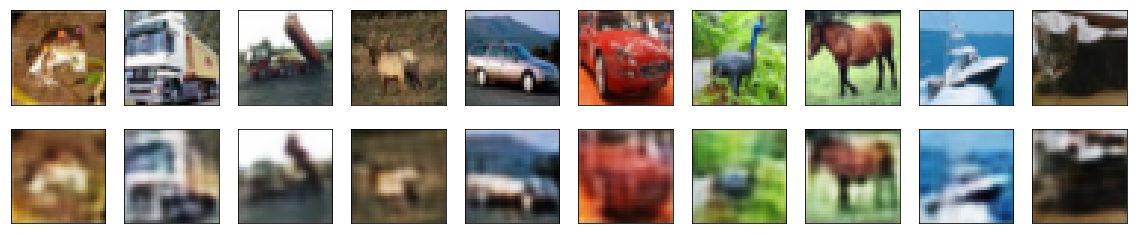

In [51]:
from cntk import load_model
from cntk.ops import combine
import matplotlib.pyplot as plt
model_file_name="07_Deconvolution_PY.model"
model_file = os.path.join(model_path, model_file_name)
loaded_model = load_model(model_file)

output_nodes = combine(
        [loaded_model.find_by_name("input_node").owner,
         loaded_model.find_by_name("pooling_node2").owner,
         loaded_model.find_by_name("output_node3").owner])

plt.figure(figsize=(20, 4))
features_si = minibatch_source_test['features']
n=10
for i in range(0, n):
    mb = minibatch_source_test.next_minibatch(1)
    raw_dict = output_nodes.eval(mb[features_si])
    output_dict = {}
    for key in raw_dict.keys(): output_dict[key.name] = raw_dict[key]
    encoder_input = output_dict["input_node"]
    #encoder_output = output_dict[enc_node_name]
    decoder_output = output_dict["output_node3"]
    in_values = (encoder_input.flatten())[np.newaxis]
    #enc_values = (encoder_output[0][0].flatten())[np.newaxis]
    out_values = (decoder_output.flatten())[np.newaxis]
    ax = plt.subplot(2, n, i + 1)
    in_values = in_values.reshape(3, 32, 32)
    in_values = in_values.transpose(1,2,0)
    in_values = np.flip(in_values,2)
    plt.imshow(in_values)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    out_values = out_values.reshape(3, 32, 32)
    out_values = out_values.transpose(1,2,0)
    out_values = np.flip(out_values,2)
    plt.imshow(out_values)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()